# QC Panels — Our vs Actual vs Plan (Europe/Tallinn)

See notebook joonistab **3×3 päevapaneelid** (kohalik aeg Europe/Tallinn, 00–23) ning eraldi **viimase päeva hajuvuse**:

- Paneel: *Actual vs Our* (+ *Plan snapshot*, kui saadaval)
- Snapshot loogika: iga päeva jaoks kasutatakse **värskeimat enne päeva** salvestatud Eleringi plaani CSV-d
- Filtrid: ainult tööpäevad / nädalavahetus / kõik
- Väljundid salvestatakse `scripts/plots` kausta

⚠️ Eeldab, et sul on olemas projektis järgmised failid:
- `scripts/forecast_vs_actual_comparison_hourly.csv` (või `_enriched.csv`) – meie forecast + actual (ja ideaalis ka plaan)
- `scripts/elering_forecast_from_YYYYMMDD.csv` – Eleringi plaan snapshot'id


In [571]:
# === BOOTSTRAP (fikseeritud kaustad + ilma .view hoiatusteta) ===
from pathlib import Path
from datetime import datetime, timedelta, timezone
import pandas as pd, numpy as np, re, requests, csv
from io import StringIO

# --- Leia projekti juurkaust mõistlikult ---
CWD = Path.cwd()
if CWD.name.lower() == "scripts":
    PROJECT = CWD.parent
else:
    PROJECT = CWD

SCRIPTS = PROJECT / "scripts"
SCRIPTS.mkdir(parents=True, exist_ok=True)

# Võimalikud forecast kaustad
CANDIDATE_OUTPUTS = [
    SCRIPTS / "output",
    PROJECT / "output",
]

# Kui ükski ei eksisteeri, loo default
for p in CANDIDATE_OUTPUTS:
    if p.exists():
        OUTPUT = p
        break
else:
    OUTPUT = SCRIPTS / "output"
    OUTPUT.mkdir(parents=True, exist_ok=True)

print("PROJECT:", PROJECT)
print("SCRIPTS :", SCRIPTS)
print("OUTPUT  :", OUTPUT)

# --- Seaded ---
DAYS_BACK = 7
today_utc  = datetime.now(timezone.utc).date()
start_date = today_utc - timedelta(days=DAYS_BACK)
end_date   = today_utc

# --- 1) Lae Eleringi actual + plan ühe päringuga (with-plan CSV) ---
from urllib.parse import urlencode
from io import StringIO

BASE_URL = "https://dashboard.elering.ee/api/system/with-plan/csv"
params = [
    ("start", f"{start_date}T00:00:00Z"),
    ("end",   f"{end_date}T23:00:00Z"),
    ("fields","consumption"),
    ("fields","consumptionPlan"),
]
url = f"{BASE_URL}?{urlencode(params)}"
r = requests.get(url, timeout=60)
r.raise_for_status()

wp = pd.read_csv(StringIO(r.text), sep=";", encoding="utf-8", low_memory=False)

# Pealkirjad ühtlaseks
rename = {
    "Ajatempel (UTC)": "timestamp",
    "Kuupäev (Eesti aeg)": "date_local",
    "Tarbimine": "consumption",
    "Planeeritud tarbimine": "plan",
    "consumptionPlan": "plan",
}
wp = wp.rename(columns=rename)

# Aeg tunnini (UTC-naive) – vältida tz konflikte
ts = pd.to_numeric(wp["timestamp"], errors="coerce")
dt_aware = pd.to_datetime(ts, unit="s", utc=True).dt.floor("h")
wp["datetime_hour_utc"] = dt_aware.dt.tz_localize(None)

# Numbrid: eemalda jutumärgid/tühikud/koma, teisenda floatiks
for c in ["consumption", "plan"]:
    if c in wp.columns:
        wp[c] = (
            wp[c].astype(str)
                 .str.replace('"', '', regex=False)
                 .str.replace(' ', '', regex=False)
                 .str.replace(',', '.', regex=False)
        )
        wp[c] = pd.to_numeric(wp[c], errors="coerce")

# Jäta üks rida tunni kohta
wp = (wp.sort_values("datetime_hour_utc")
         .drop_duplicates(subset=["datetime_hour_utc"], keep="last"))

# --- 1a) Salvesta (ilma .view hoiatuseta) ---
epoch_sec = (dt_aware.astype("int64") // 10**9)

actual_path = SCRIPTS / f"elering_actual_from_{start_date:%Y%m%d}.csv"
pd.DataFrame({
    "Ajatempel (UTC)": epoch_sec,
    "Tarbimine": wp["consumption"]
}).to_csv(actual_path, sep=";", index=False, encoding="utf-8")
print("Salvestatud actual:", actual_path)

plan_path = SCRIPTS / f"elering_forecast_from_{start_date:%Y%m%d}.csv"
pd.DataFrame({
    "Ajatempel (UTC)": epoch_sec,
    "Planeeritud tarbimine": wp["plan"]
}).to_csv(plan_path, sep=";", index=False, encoding="utf-8")
print("Salvestatud Eleringi plaan (snapshot):", plan_path)

awp_path = SCRIPTS / "elering_actual_with_plan.csv"
pd.DataFrame({
    "Ajatempel (UTC)": epoch_sec,
    "Tarbimine": wp["consumption"],
    "Planeeritud tarbimine": wp["plan"],
}).to_csv(awp_path, sep=";", index=False, encoding="utf-8")
print("Salvestatud actual_with_plan:", awp_path)

# Hoia kopeerituna hilisemaks võrdluseks/nimega, mida ülejäänud notebook eeldab
raw_df = wp.copy()  # <--- lisatud, et hilisemad cellid (act = raw_df ...) ei annaks NameError

# --- 2) Leia ja koonda KÕIK forecast failid (mitte ainult viimane) ---
pattern = "forecast_consumption_hourly_next7_tallinn_*.csv"

fc_files = []
for p in CANDIDATE_OUTPUTS:
    if p.exists():
        fc_files += sorted(p.glob(pattern))

if not fc_files:
    # viimane õlekõrs: otsi kogu projekti alt rekursiivselt
    fc_files = sorted(PROJECT.rglob(pattern))

if not fc_files:
    raise FileNotFoundError(
        "Ei leitud forecast-faile. Otsiti asukohtadest:\n"
        + "\n".join(f"- {p}" for p in CANDIDATE_OUTPUTS)
        + f"\nja rekursiivselt projekti alt: {PROJECT}"
    )

print("Leitud forecaste:")
for _fp in fc_files[-10:]:
    print(" -", _fp)

# --- robustne CSV lugeja ---
def read_csv_robust(path: Path) -> pd.DataFrame:
    encodings = ["utf-8","cp1257","latin1"]
    delims    = [",",";","\t","|"]
    decimals  = [",","."]
    try:
        with open(path,"rb") as f:
            raw = f.read(4096)
    except Exception:
        raw = None
    for enc in encodings:
        sample = None
        if raw:
            try:
                sample = raw.decode(enc, errors="strict")
            except Exception:
                sample = None
        snif = None
        if sample:
            try:
                snif = csv.Sniffer().sniff(sample, delimiters=delims).delimiter
            except Exception:
                head = sample.splitlines()[0] if sample else ""
                snif = ";" if head.count(";")>=head.count(",") else ","
        for sep in ([snif] if snif else delims):
            for dec in decimals:
                try:
                    df = pd.read_csv(path, sep=sep, encoding=enc, decimal=dec, skipinitialspace=True)
                except Exception:
                    continue
                if len(df.columns)==1 and ("," in df.columns[0] or ";" in df.columns[0]):
                    continue
                return df
    return pd.read_csv(path)

# --- ajaveeru ehitamine (robustne tz-käsitlus; alati UTC-naive) ---
def build_datetime_hour(df: pd.DataFrame) -> pd.Series:
    if "datetime_hour" in df.columns:
        s = pd.to_datetime(df["datetime_hour"], errors="coerce", utc=True)
        return s.dt.floor("h").dt.tz_localize(None)
    if "datetime_local" in df.columns:
        s = pd.to_datetime(df["datetime_local"], errors="coerce")
        if getattr(s.dt, "tz", None) is not None:
            s_utc = s.dt.tz_convert("UTC")
        else:
            s_loc = s.dt.tz_localize("Europe/Tallinn", nonexistent="shift_forward", ambiguous="NaT")
            s_utc = s_loc.dt.tz_convert("UTC")
        return s_utc.dt.tz_localize(None).dt.floor("h")
    if "date_local" in df.columns and "hour_local" in df.columns:
        d = pd.to_datetime(df["date_local"], errors="coerce")
        h = pd.to_numeric(df["hour_local"], errors="coerce").fillna(0).astype(int)
        s = (d + pd.to_timedelta(h, unit="h")).dt.tz_localize("Europe/Tallinn", nonexistent="shift_forward", ambiguous="NaT")
        return s.dt.tz_convert("UTC").dt.tz_localize(None).dt.floor("h")
    if "timestamp" in df.columns:
        s = pd.to_datetime(pd.to_numeric(df["timestamp"], errors="coerce"), unit="s", utc=True)
        return s.dt.floor("h").dt.tz_localize(None)
    raise ValueError(f"Forecast failis puudub sobiv ajaveerg (leidsin: {list(df.columns)})")

# --- loe ja koonda kõik forecastid ---

def _parse_range_from_name(path: Path):
    m = re.search(r"_(\d{8})_(\d{8})\.csv$", path.name)
    if m:
        s = pd.to_datetime(m.group(1), format="%Y%m%d")
        e = pd.to_datetime(m.group(2), format="%Y%m%d")
        return s, e
    return None, None

frames = []
for fp in fc_files:
    try:
        dfp = read_csv_robust(fp)
        dt = build_datetime_hour(dfp)
    except Exception as ex:
        print("⚠️ Vahele jäetud (lugemise viga):", fp, "—", ex)
        continue

    val_col = None
    for cand in ["consumption_hourly","yhat_consumption","yhat_base"]:
        if cand in dfp.columns:
            val_col = cand; break
    if val_col is None:
        print("⚠️ Vahele jäetud (puudub väärtuse veerg):", fp)
        continue

    our_vals = pd.to_numeric(
        dfp[val_col].astype(str).str.replace('"','', regex=False).str.replace(' ','', regex=False).str.replace(',','.', regex=False),
        errors="coerce"
    )
    s, e = _parse_range_from_name(fp)
    fr = pd.DataFrame({
        "datetime_hour": dt,
        "our": our_vals,
        "h_start": s,
        "h_end": e,
        "_src": str(fp)
    }).dropna(subset=["datetime_hour","our"]).sort_values("datetime_hour")

    # kui failinimi sisaldas vahemikku, filtreeri selle järgi
    if s is not None and e is not None:
        fr = fr[(fr["datetime_hour"] >= s) & (fr["datetime_hour"] <= (e + pd.Timedelta(hours=23)))]
    frames.append(fr)

if not frames:
    raise RuntimeError("Ühtegi sobivat forecastit ei õnnestunud koondada.")

all_forecasts = pd.concat(frames, ignore_index=True)

# vali iga tunni jaoks kõige hilisem h_start, mis on <= sellest tunnist
# arvuta 'age_sec' = kui palju aega on möödunud h_start'ist (ainult kui h_start<=tund)
mask_ok = all_forecasts["h_start"].notna()
all_forecasts["age_sec"] = np.where(
    mask_ok & (all_forecasts["h_start"] <= all_forecasts["datetime_hour"]),
    (all_forecasts["datetime_hour"] - all_forecasts["h_start"]).dt.total_seconds(),
    np.nan
)

# kui h_start puudus, märgi eraldi suureks väärtuseks, et liigne ei domineeriks
all_forecasts.loc[~mask_ok, "age_sec"] = np.inf

# vali iga datetime_hour kohta min(age_sec) rida
idx = all_forecasts.groupby("datetime_hour")["age_sec"].idxmin()
fdf = all_forecasts.loc[idx, ["datetime_hour","our"]].sort_values("datetime_hour")

# --- 3) Koosta comparison = (actual_with_plan) ⟂ our forecast ---
# NB: raw_df["datetime_hour_utc"] on UTC-naive
act = raw_df.rename(columns={"datetime_hour_utc":"datetime_hour"})[["datetime_hour","consumption","plan"]]
cmp = pd.merge(act, fdf, on="datetime_hour", how="right").sort_values("datetime_hour")

if "consumption" in cmp.columns:
    cmp["viga"] = cmp["our"] - cmp["consumption"]
    cmp["viga_protsent"] = 100*cmp["viga"]/cmp["consumption"]
if "plan" in cmp.columns:
    cmp["viga_vs_elering_forecast"] = cmp["our"] - cmp["plan"]
    cmp["viga_vs_elering_forecast_protsent"] = 100*cmp["viga_vs_elering_forecast"]/cmp["plan"]
    cmp["viga_actual_vs_elering_forecast"] = cmp["consumption"] - cmp["plan"]
    cmp["viga_actual_vs_elering_forecast_protsent"] = 100*cmp["viga_actual_vs_elering_forecast"]/cmp["plan"]

cmp_save = cmp.copy()
cmp_save["Ajatempel (UTC)"] = (cmp_save["datetime_hour"].astype("int64") // 10**9)
cmp_save = cmp_save.rename(columns={
    "consumption":"Tarbimine",
    "our":"consumption_hourly",
    "plan":"elering_forecast"
})

cmp_basic_path = SCRIPTS / "forecast_vs_actual_comparison_hourly.csv"
cmp_enrich_path = SCRIPTS / "forecast_vs_actual_comparison_hourly_enriched.csv"
cmp_save.to_csv(cmp_basic_path, sep=";", index=False, encoding="utf-8")
cmp_save.to_csv(cmp_enrich_path, sep=";", index=False, encoding="utf-8")
print("Salvestatud comparison:", cmp_basic_path)
print("Salvestatud comparison enriched:", cmp_enrich_path)

print("\n✅ BOOTSTRAP OK — sisendid loodud/uuendatud.")

PROJECT: c:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast
SCRIPTS : c:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts
OUTPUT  : c:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output
Salvestatud actual: c:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\elering_actual_from_20250918.csv
Salvestatud Eleringi plaan (snapshot): c:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\elering_forecast_from_20250918.csv
Salvestatud actual_with_plan: c:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\elering_actual_with_plan.csv
Leitud forecaste:
 - c:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\output\forecast_consumption_hourly_next7_tallinn_20

In [572]:
# === Seaded ===
DAY_FILTER   = "all"        # "workdays" | "weekends" | "all"
DAY_SCOPE    = "past"       # "past" | "future" — vali mineviku viimased N päeva või tuleviku järgmised N
REQUIRE_PLAN = False        # kui True: kuva vaid päevad, millel on plaani snapshot
REQUIRE_PLAN_MIN_HOURS = 24 # mitu tundi peab plaanist olema (0..24). Nt 12 lubab poolikut plaani
N_DAYS       = 7            # mitu päeva paneelile
TZ           = "Europe/Tallinn"
VERBOSE      = True         # kui True: prindi detailne diagnostika

from pathlib import Path
import pandas as pd, numpy as np, re, matplotlib.pyplot as plt

# Kasuta globaalsest BOOTSTRAP-cellist tulnud SCRIPTS teed
try:
    _ = SCRIPTS
except NameError:
    SCRIPTS = Path.cwd() / "scripts"

PLOTS_DIR = SCRIPTS / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
print("Pildid salvestatakse:", PLOTS_DIR.resolve())
print(f"Seaded: DAY_FILTER={DAY_FILTER}, DAY_SCOPE={DAY_SCOPE}, REQUIRE_PLAN={REQUIRE_PLAN}, REQUIRE_PLAN_MIN_HOURS={REQUIRE_PLAN_MIN_HOURS}, N_DAYS={N_DAYS}")

Pildid salvestatakse: C:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\plots
Seaded: DAY_FILTER=all, DAY_SCOPE=past, REQUIRE_PLAN=False, REQUIRE_PLAN_MIN_HOURS=24, N_DAYS=7


In [573]:
# === Funktsioon: plan_snapshot_for_local_day ===
# Eesmärk: tagastada DataFrame veergudega hour_local, plan_snapshot
# Loogika: leiab kõige värskema enne päeva (päeva alguse UTC) salvestatud Eleringi plaanifaili,
# konverteerib selle kohalikku aega ja filtreerib ainult selle päeva 00-23 tunnid (Europe/Tallinn).
# min_hours: minimaalne tundide arv, et snapshot kvalifitseeruks (nt 24 = täispäev)
from pathlib import Path
import pandas as pd
import numpy as np
import re

# Kasutame juba bootstrapis defineeritud PROJECT ja SCRIPTS

ELERING_PLAN_PATTERN = re.compile(r"elering_forecast_from_(\d{8})\.csv$")

# Cache, et mitte korduvalt sama faili lugeda
__plan_cache = {}

def _load_plan_file(path: Path) -> pd.DataFrame:
    if path in __plan_cache:
        return __plan_cache[path]
    try:
        dfp = pd.read_csv(path, sep=';', encoding='utf-8', low_memory=False)
    except Exception:
        dfp = pd.read_csv(path, sep=';', encoding='cp1257', low_memory=False)
    # Normalizeeri ajaveerg
    ts_col = None
    for cand in ["Ajatempel (UTC)", "timestamp"]:
        if cand in dfp.columns:
            ts_col = cand; break
    if ts_col is None:
        raise ValueError(f"Plan failis puudub ajatempel: {path}")
    ts = pd.to_numeric(dfp[ts_col], errors='coerce')
    dt_utc = pd.to_datetime(ts, unit='s', utc=True).dt.floor('h')
    # Salvestame UTC-naive (no tz), et oleks ühtlane käsitlus
    out = pd.DataFrame({
        'datetime_hour_utc': dt_utc.dt.tz_localize(None),
        'plan': pd.to_numeric(
            dfp.get('Planeeritud tarbimine', dfp.get('plan'))
                .astype(str)
                .str.replace('"','', regex=False)
                .str.replace(' ','', regex=False)
                .str.replace(',','.', regex=False), errors='coerce')
    }).dropna(subset=['datetime_hour_utc'])
    __plan_cache[path] = out
    return out

# Leia kõik snapshot-failid (elering_forecast_from_YYYYMMDD.csv) SCRIPTS kaustast

def _list_plan_files():
    files = []
    for p in [SCRIPTS]:
        if p.exists():
            for f in p.glob('elering_forecast_from_*.csv'):
                if ELERING_PLAN_PATTERN.search(f.name):
                    files.append(f)
    return sorted(files)

# Rakenda snapshot loogika

def plan_snapshot_for_local_day(day_local, tz='Europe/Tallinn', min_hours=0):
    """
    Tagastab DataFrame (hour_local, plan_snapshot) või None, kui ei leia min_hours künnist.
    day_local: pd.Timestamp / date (naive, kohalik kuupäev)
    Loogika: vali kõige hilisem snapshot faili kuupäev, mis on <= day_local.
    """
    day_local = pd.to_datetime(day_local).floor('D')
    plan_files = _list_plan_files()
    if not plan_files:
        return None
    # Ekstraheerime failinimedest snapshot'i alguskuupäeva
    rows = []
    for f in plan_files:
        m = ELERING_PLAN_PATTERN.search(f.name)
        if not m:
            continue
        snap_date = pd.to_datetime(m.group(1), format='%Y%m%d')
        rows.append((snap_date, f))
    if not rows:
        return None
    # Filtreeri snapshotid, mis on <= day_local (ehk olemas enne selle päeva algust)
    eligible = [(d,f) for (d,f) in rows if d <= day_local]
    if not eligible:
        return None
    # Võta neist kõige hilisem (max kuupäev)
    snap_date, snap_file = sorted(eligible, key=lambda x: x[0])[-1]

    try:
        dfp = _load_plan_file(snap_file)
    except Exception as ex:
        print(f"⚠️ Snapshoti lugemise viga ({snap_file}):", ex)
        return None

    # Konverteeri kohalikku aega: algandmed on UTC-naive -> tõlgenda UTC -> konverteeri kohalikku -> tee jälle naive
    dt_local = (pd.to_datetime(dfp['datetime_hour_utc'], utc=True)
                  .dt.tz_convert(tz)
                  .dt.tz_localize(None))
    dfp_local = pd.DataFrame({
        'dt_local': dt_local,
        'hour_local': dt_local.dt.hour,
        'day_local': dt_local.dt.floor('D'),
        'plan_snapshot': dfp['plan']
    })

    s_day = dfp_local[dfp_local['day_local'] == day_local].copy()
    s_day = s_day.sort_values('hour_local')
    # Filtreeri ainult 0..23 tunnid (mõnikord API võib anda lisa tunde DST tõttu)
    s_day = s_day[s_day['hour_local'].between(0,23)]

    if s_day['hour_local'].nunique() < int(min_hours):
        return None
    return s_day[['hour_local','plan_snapshot']]

print("Funktsioon plan_snapshot_for_local_day lisatud. Snapshot-faile:", len(_list_plan_files()))
print("Test (täna-1):", plan_snapshot_for_local_day(pd.Timestamp.now().floor('D') - pd.Timedelta(days=1), min_hours=0) is not None)

Funktsioon plan_snapshot_for_local_day lisatud. Snapshot-faile: 3
Test (täna-1): True


In [574]:
# === Lae comparison-andmed robustselt ===
from pathlib import Path
import pandas as pd

# Kasuta SCRIPTS kausta
try:
    _ = SCRIPTS
except NameError:
    SCRIPTS = Path.cwd() / "scripts"

comp_main = SCRIPTS/"forecast_vs_actual_comparison_hourly.csv"
comp_alt  = SCRIPTS/"forecast_vs_actual_comparison_hourly_enriched.csv"

if comp_main.is_file():
    df = pd.read_csv(comp_main, sep=';', encoding='utf-8', low_memory=False)
    print("Laetud:", comp_main)
elif comp_alt.is_file():
    df = pd.read_csv(comp_alt, sep=';', encoding='utf-8', low_memory=False)
    print("Laetud:", comp_alt)
else:
    raise FileNotFoundError("Puudub scripts/forecast_vs_actual_comparison_hourly(.csv|_enriched.csv)")

# normalizeeri võimalikud duplikaadid elering_forecast_x/y
if 'elering_forecast' not in df.columns and ('elering_forecast_x' in df.columns or 'elering_forecast_y' in df.columns):
    df['elering_forecast'] = df.get('elering_forecast_x')
    if 'elering_forecast_y' in df.columns:
        df['elering_forecast'] = df['elering_forecast'].combine_first(df['elering_forecast_y'])

print("Veerud:", list(df.columns)[:12], '...')
print("Read:", len(df))

Laetud: c:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\forecast_vs_actual_comparison_hourly.csv
Veerud: ['datetime_hour', 'Tarbimine', 'elering_forecast', 'consumption_hourly', 'viga', 'viga_protsent', 'viga_vs_elering_forecast', 'viga_vs_elering_forecast_protsent', 'viga_actual_vs_elering_forecast', 'viga_actual_vs_elering_forecast_protsent', 'Ajatempel (UTC)'] ...
Read: 333


In [575]:
# === Abi: ajad Tallinna ajaks; base DataFrame ===
import pandas as pd

def to_local(dt_series, tz=TZ):
    s = pd.to_datetime(dt_series, errors="coerce")
    if getattr(s.dt, "tz", None) is None:
        s = s.dt.tz_localize("UTC")
    s = s.dt.tz_convert(tz)
    return s.dt.tz_localize(None)

base = df.copy()
if "datetime_hour" not in base.columns:
    # püüa Ajatempel (UTC) -> sekundid
    if 'Ajatempel (UTC)' in base.columns:
        ts = pd.to_numeric(base['Ajatempel (UTC)'], errors='coerce')
        base['datetime_hour'] = pd.to_datetime(ts, unit='s', utc=True)
    else:
        raise ValueError("Puudub 'datetime_hour' või 'Ajatempel (UTC)'.")

base['dt_local']  = to_local(base['datetime_hour'])
base['day_local'] = base['dt_local'].dt.floor('D')
base['hour_local']= base['dt_local'].dt.hour

# vali väärtuse veerud
col_actual = 'Tarbimine' if 'Tarbimine' in base.columns else ('consumption' if 'consumption' in base.columns else None)
col_our    = 'consumption_hourly' if 'consumption_hourly' in base.columns else None
col_plan   = 'elering_forecast' if 'elering_forecast' in base.columns else ('plan' if 'plan' in base.columns else None)
if not all([col_actual, col_our]):
    raise ValueError(f"Puuduvad veerud: actual={col_actual}, our={col_our}")

for c in [col_actual, col_our] + ([col_plan] if col_plan else []):
    if c and c in base.columns:
        base[c] = pd.to_numeric(base[c], errors='coerce')

used = ['dt_local','day_local','hour_local', col_actual, col_our] + ([col_plan] if col_plan else [])
base = base[used].rename(columns={col_actual:'actual', col_our:'our', (col_plan if col_plan else 'dummy'):'plan'}).sort_values(['day_local','hour_local'])
if 'plan' not in base.columns:
    print('⚠️ NB: comparison-tabelist puudub plaani veerg; plaan võetakse ainult snapshot-failidest.')

In [576]:
# === Päevade valik (täis 24h meie prognoosi) + filtrid [diagnoosi jaoks jäetud] ===
# NB: Paneeli fikseeritud loogika on paneelitsellis, see cell jääb diagnostikaks
full_days_ours = base.groupby('day_local')['our'].apply(lambda x: x.notna().sum()==24)
full_days_actual = base.groupby('day_local')['actual'].apply(lambda x: x.notna().sum()==24)

diag = (
    pd.DataFrame({
        'our_24': full_days_ours,
        'actual_24': full_days_actual
    })
    .reset_index()
    .rename(columns={'index':'day_local'})
    .sort_values('day_local')
)

if VERBOSE:
    print("\n— Päevade kvaliteet (diagnoos) —")
    display(diag.tail(20))

# Varem ehitatud filtreerimisloogika pole enam kriitiline paneelile
now_local = pd.Timestamp.now(tz=TZ).tz_localize(None)
today_local = now_local.floor('D')
print("Diagnoosi tänane kuupäev:", today_local.date())


— Päevade kvaliteet (diagnoos) —


,day_local,our_24,actual_24
0,2025-09-18,False,False
1,2025-09-19,True,True
2,2025-09-20,True,True
3,2025-09-21,True,True
4,2025-09-22,True,True
5,2025-09-23,True,True
6,2025-09-24,True,True
7,2025-09-25,True,False
8,2025-09-26,True,False
9,2025-09-27,True,False


Diagnoosi tänane kuupäev: 2025-09-25


Paneelis kuvatavad päevad: ['2025-09-19', '2025-09-20', '2025-09-21', '2025-09-22', '2025-09-23', '2025-09-24', '2025-09-25', '2025-09-26']


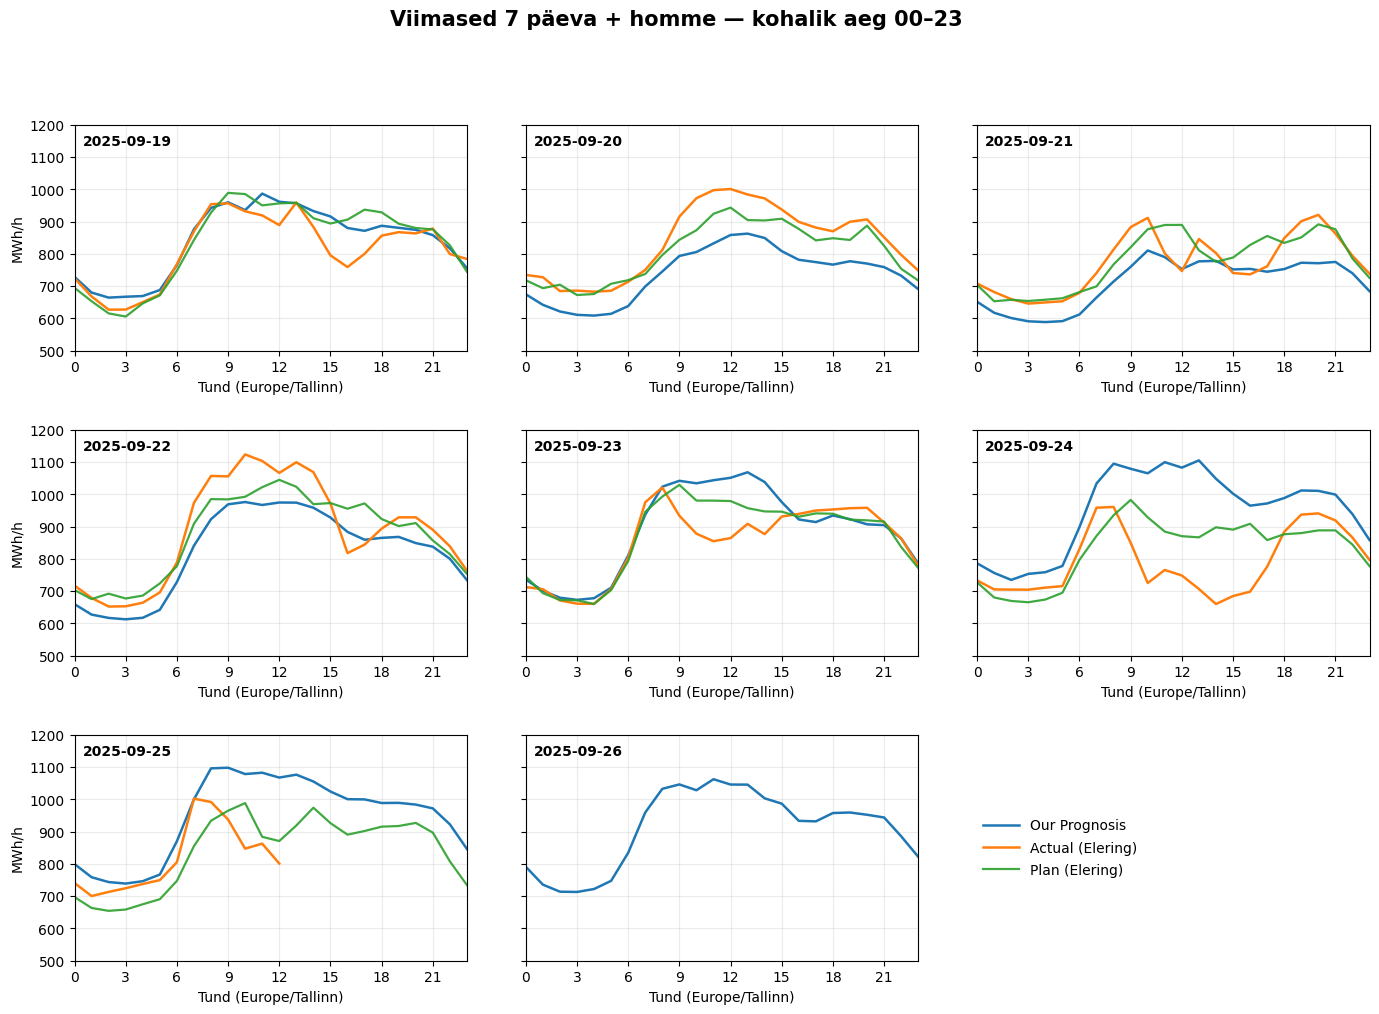

Salvestatud: c:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\plots\panel_local_all.png


In [577]:
# === 3×3 LINE PANEEL — 9. ruut = legend (vertikaalne), ühtne Y-skaala ===
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd

rows, cols = 3, 3
fig = plt.figure(figsize=(14, 11))
# Legendile oma eraldi rida eemaldatud — kasutame vajadusel 9. ruutu
gs = GridSpec(rows, cols, hspace=0.35, wspace=0.15, figure=fig)

axes = [fig.add_subplot(gs[r, c]) for r in range(rows) for c in range(cols)]

# Päevade loogika
now_local    = pd.Timestamp.now(tz=TZ).tz_localize(None)
today_local  = now_local.floor('D')
tomorrow_loc = today_local + pd.Timedelta(days=1)
past_days    = [today_local - pd.Timedelta(days=i) for i in range(6, -1, -1)]
days_all     = past_days + [tomorrow_loc]
print('Paneelis kuvatavad päevad:', [str(d.date()) for d in days_all])

# Fikseeritud värvid ja stiilid
COLORS = {
    'Our Prognosis': '#1f77b4',        # sinine
    'Actual (Elering)': '#ff7f0e',     # oranž
    'Plan (Elering)': '#2ca02c'        # roheline
}
STYLES = {
    'Our Prognosis': {'linewidth': 1.8},
    'Actual (Elering)': {'linewidth': 1.8},
    'Plan (Elering)': {'linewidth': 1.6, 'alpha': 0.9}
}

legend_handles, legend_labels = [], []

def add_legend_item(h, label):
    if h is None:
        return
    if label not in legend_labels:
        legend_handles.append(h)
        legend_labels.append(label)

# --- Ühtne Y-skaala kõigile alamgraafikutele ---
y_min, y_max = float("inf"), float("-inf")

def _nice_step(span):
    # vali mõistlik aste nii, et jaotisi oleks kuni ~8
    candidates = [25, 50, 100, 200, 250, 500, 1000]
    for st in candidates:
        if span / st <= 8:
            return st
    return max(1000, span / 8.0)

for i, ax in enumerate(axes):
    # Kui 9. ruut kasutame legendiks (8 päeva), siis see jääb loopis tühjaks niikuinii
    if i >= len(days_all):
        ax.axis('off')
        continue

    d = days_all[i]
    s = base[base['day_local'].dt.floor('D') == pd.to_datetime(d).floor('D')].sort_values('hour_local')

    is_future = pd.to_datetime(d).floor('D') > today_local
    has_any = False

    # OUR
    if 'our' in s.columns and s['our'].notna().any():
        yO = pd.to_numeric(s['our'], errors='coerce')
        if yO.notna().any():
            hO = ax.plot(
                s['hour_local'], yO,
                label='Our Prognosis',
                color=COLORS['Our Prognosis'], **STYLES['Our Prognosis']
            )[0]
            add_legend_item(hO, 'Our Prognosis'); has_any = True
            y_min = min(y_min, float(yO.min()))
            y_max = max(y_max, float(yO.max()))

    # ACTUAL — ära joonista tulevikupäeval
    if (not is_future) and 'actual' in s.columns and s['actual'].notna().any():
        yA = pd.to_numeric(s['actual'], errors='coerce')
        if yA.notna().any():
            hA = ax.plot(
                s['hour_local'], yA,
                label='Actual (Elering)',
                color=COLORS['Actual (Elering)'], **STYLES['Actual (Elering)']
            )[0]
            add_legend_item(hA, 'Actual (Elering)'); has_any = True
            y_min = min(y_min, float(yA.min()))
            y_max = max(y_max, float(yA.max()))

    # PLAN (snapshot)
    ps = plan_snapshot_for_local_day(d, min_hours=int(REQUIRE_PLAN_MIN_HOURS))
    if ps is not None and len(ps):
        yP = pd.to_numeric(ps['plan_snapshot'], errors='coerce')
        if yP.notna().any():
            hP = ax.plot(
                ps['hour_local'], yP,
                label='Plan (Elering)',
                color=COLORS['Plan (Elering)'], **STYLES['Plan (Elering)']
            )[0]
            add_legend_item(hP, 'Plan (Elering)')
            has_any = True
            y_min = min(y_min, float(yP.min()))
            y_max = max(y_max, float(yP.max()))

    # Pealkiri telje sees vasakus ülanurgas
    title_txt = f"{pd.to_datetime(d).date()}"
    ax.text(0.02, 0.96, title_txt, transform=ax.transAxes, ha='left', va='top',
            fontsize=10, fontweight='semibold')

    if not has_any:
        ax.text(0.5, 0.5, 'Andmeid pole', ha='center', va='center', transform=ax.transAxes, alpha=0.6)

    ax.set_xlim(0, 23); ax.set_xticks(range(0, 24, 3))

    # Näita X-telje silte kõigil alamgraafikutel
    ax.set_xlabel('Tund (Europe/Tallinn)')
    ax.tick_params(axis='x', labelbottom=True)

    # Y-telje sildid ainult vasak veerg
    if i % cols == 0:
        ax.set_ylabel('MWh/h')
    else:
        ax.tick_params(axis='y', labelleft=False)

    ax.grid(True, alpha=0.25)

# Rakenda ühtne Y-skaala
if np.isfinite(y_min) and np.isfinite(y_max) and y_min < y_max:
    pad = 20.0  # veidi õhku piiridele
    lo = max(0.0, np.floor((y_min - pad) / 25.0) * 25.0)  # mitte alla nulli
    hi = np.ceil((y_max + pad) / 25.0) * 25.0
    span = max(hi - lo, 1.0)
    step = _nice_step(span)
    lo = np.floor(lo / step) * step
    hi = np.ceil(hi / step) * step
    yticks = np.arange(lo, hi + 0.5 * step, step)

    for ax in axes:
        if ax.has_data():
            ax.set_ylim(lo, hi)
            ax.set_yticks(yticks)

# Legend — 9. ruut (vertikaalne) kui vaba; muidu figuuri paremal vertikaalselt
use_legend_cell = (len(days_all) <= 8)
if legend_handles:
    if use_legend_cell:
        legend_ax = axes[-1]
        legend_ax.cla()
        legend_ax.axis('off')
        legend_ax.legend(
            legend_handles, legend_labels,
            loc='center left',
            ncol=1,
            frameon=False,
            handlelength=2.6,
            columnspacing=1.4,
            handletextpad=0.8,
            borderaxespad=0.0,
            labelspacing=0.6,
            fontsize=10
        )
    else:
        fig.legend(
            legend_handles, legend_labels,
            loc='center right',
            ncol=1,
            frameon=False,
            bbox_to_anchor=(0.995, 0.5)
        )
        # jäta paremale natuke ruumi figuuri-legendile
        fig.subplots_adjust(right=0.92)

# Ühtne pealkiri
fig.suptitle('Viimased 7 päeva + homme — kohalik aeg 00–23', y=0.985, fontsize=15, fontweight='bold')

# Paigutus: kuna legend on ruudus/paremal, hoiame mõõdukad vahed
fig.subplots_adjust(top=0.88, bottom=0.12, left=0.07, right=0.995, hspace=0.35, wspace=0.15)

out_panel = PLOTS_DIR / f"panel_local_{DAY_FILTER}{'_planreq' if REQUIRE_PLAN else ''}.png"
fig.savefig(out_panel, dpi=144)
plt.show()
print('Salvestatud:', out_panel)

In [578]:
# --- DIAG: miks hajuvus võib olla tühi (kontrolli viimast paneelipäeva) ---
print("Paneelis olevad päevad:", [str(pd.to_datetime(d).date()) for d in days_all])
if days_all:
    d_last = max(days_all)
    print("Diagnoositav päev:", pd.to_datetime(d_last).date())
    s_dbg = base[base['day_local'] == d_last].sort_values('hour_local')

    print("our N:", int(pd.to_numeric(s_dbg['our'], errors='coerce').notna().sum()))
    print("actual N:", int(pd.to_numeric(s_dbg['actual'], errors='coerce').notna().sum()))

    ps_dbg = plan_snapshot_for_local_day(d_last, min_hours=0)
    plan_hours = int(ps_dbg['hour_local'].nunique()) if ps_dbg is not None else 0
    print("plan_snapshot tunniarv:", plan_hours)
else:
    print("Paneelis pole ühtegi päeva (kontrolli filtreid).")


Paneelis olevad päevad: ['2025-09-19', '2025-09-20', '2025-09-21', '2025-09-22', '2025-09-23', '2025-09-24', '2025-09-25', '2025-09-26']
Diagnoositav päev: 2025-09-26
our N: 24
actual N: 0
plan_snapshot tunniarv: 3


In [579]:
print("days_all:", [str(pd.to_datetime(d).date()) for d in days_all])

# miks 18.09 välja kukkus?
check_days = pd.date_range(pd.to_datetime(days_all[0]) - pd.Timedelta(days=2),
                           pd.to_datetime(days_all[-1]) + pd.Timedelta(days=1), freq="D")
rows=[]
for d in check_days:
    s = base[base['day_local']==d]
    rows.append({
        "day_local": d.date(),
        "our_hours": int(s['our'].notna().sum()),
        "actual_hours": int(s['actual'].notna().sum()),
        "plan_snapshot_hours": (plan_snapshot_for_local_day(d, min_hours=0)['hour_local'].nunique()
                                if plan_snapshot_for_local_day(d, min_hours=0) is not None else 0)
    })
display(pd.DataFrame(rows))


days_all: ['2025-09-19', '2025-09-20', '2025-09-21', '2025-09-22', '2025-09-23', '2025-09-24', '2025-09-25', '2025-09-26']


,day_local,our_hours,actual_hours,plan_snapshot_hours
0,2025-09-17,0,0,21
1,2025-09-18,21,21,21
2,2025-09-19,24,24,24
3,2025-09-20,24,24,24
4,2025-09-21,24,24,24
5,2025-09-22,24,24,24
6,2025-09-23,24,24,24
7,2025-09-24,24,24,24
8,2025-09-25,24,13,24
9,2025-09-26,24,0,3


In [580]:
# === Päevamõõdikud tabelina ===
import pandas as pd

def daily_metrics_local(d):
    s = base[base['day_local']==d].sort_values('hour_local')
    err_abs = (s['our'] - s['actual']).abs()
    return {
        'day_local': pd.to_datetime(d).date(),
        'N': int(err_abs.notna().sum()),
        'avg_abs_err_MWh': float(err_abs.mean()),
        'max_abs_err_MWh': float(err_abs.max()),
        'min_abs_err_MWh': float(err_abs.min()),
    }

metrics = pd.DataFrame([daily_metrics_local(d) for d in days_all])
# Formaat 1 koht pärast koma ja paremale joondus
num_cols = ['avg_abs_err_MWh','max_abs_err_MWh','min_abs_err_MWh']
for c in num_cols:
    if c in metrics.columns:
        metrics[c] = metrics[c].map(lambda v: f"{v:.1f}" if pd.notna(v) else "")
# Tagame, et N oleks paremale joondatav string
metrics['N'] = metrics['N'].map(lambda v: f"{v}" )
# Kuvame Styleriga, parem joondus
styled_metrics = (metrics.style
                  .set_table_styles([
                      {'selector':'th','props':[('text-align','center'),('padding','4px 8px'),('background','#0f172a'),('color','#fff')]},
                      {'selector':'td','props':[('text-align','right'),('padding','4px 8px'),('font-family','monospace')]},
                  ])
                 )
display(styled_metrics)
metrics_path = PLOTS_DIR / f"daily_metrics_local_{DAY_FILTER}.csv"
# Salvestame CSV eraldi ilma format transformatsioonita – arvulised väärtused toorandmetena
raw_for_save = pd.DataFrame([daily_metrics_local(d) for d in days_all])
raw_for_save.to_csv(metrics_path, sep=';', index=False, encoding='utf-8')
print('Salvestatud:', metrics_path)

,day_local,N,avg_abs_err_MWh,max_abs_err_MWh,min_abs_err_MWh
0,2025-09-19,24,32.5,121.0,2.5
1,2025-09-20,24,99.7,166.8,51.3
2,2025-09-21,24,64.5,149.8,6.3
3,2025-09-22,24,71.8,147.4,15.2
4,2025-09-23,24,54.0,188.9,0.1
5,2025-09-24,24,159.9,398.3,30.1
6,2025-09-25,13,95.1,266.3,1.9
7,2025-09-26,0,,,


Salvestatud: c:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\plots\daily_metrics_local_all.csv


In [581]:
# === APE% sparklines: ultra-kompaktne rea kõrgus ===
from IPython.display import HTML, display

compact_css = """
<style>
  .ape-compact table { border-collapse: collapse; font-size: 11px; table-layout: fixed; width: 100%; }
  .ape-compact th, .ape-compact td { padding: 0 2px; line-height: 0.9; height: 0.9em; vertical-align: middle; }
  .ape-compact th { font-weight: 600; }
  /* tee sparklines veel madalamaks */
  .ape-compact img, .ape-compact svg, .ape-compact canvas { height: 0.8em !important; width: auto; display: inline-block; vertical-align: middle; }
</style>
"""

src = globals().get('ape_html', '')

if src:
    ape_section = f"<div class='ape-compact'>{compact_css}{src}</div>"
    globals()['ape_section'] = ape_section
    display(HTML(ape_section))
else:
    print("APE% HTML puudub (ape_html).")

,spark,2025-09-19,2025-09-20,2025-09-21,2025-09-22,2025-09-23,2025-09-24,2025-09-25
00:00,,0.60%,8.17%,7.98%,8.01%,3.27%,7.20%,7.94%
01:00,,1.80%,11.75%,9.42%,7.61%,0.72%,7.25%,8.32%
02:00,,5.96%,9.24%,8.89%,5.41%,1.27%,4.28%,4.27%
03:00,,6.33%,10.94%,8.50%,6.16%,1.78%,6.95%,1.99%
04:00,,2.89%,10.83%,9.38%,7.02%,2.64%,6.72%,1.18%
05:00,,2.07%,10.43%,9.45%,7.75%,0.56%,8.73%,2.29%
06:00,,0.40%,10.55%,9.87%,7.67%,0.91%,8.19%,8.07%
07:00,,0.78%,6.84%,10.25%,13.65%,3.92%,7.83%,0.19%
08:00,,1.21%,8.19%,12.19%,12.68%,0.26%,13.95%,10.50%
09:00,,0.34%,13.31%,13.94%,8.18%,11.60%,26.98%,17.12%


In [582]:
# === APE% (Our vs Actual) — tunnid × päevad — sparklines (HTML) / (re)build ===
import numpy as np, pandas as pd

# Väike inline sparkline SVG (üks rida)
def _ape_spark_svg(vals: pd.Series, width=90, height=28, pad=4) -> str:
    s = pd.to_numeric(vals, errors='coerce')
    m = s.notna()
    if m.sum() <= 1:
        return f"<svg width='{width}' height='{height}' viewBox='0 0 {width} {height}'/>"
    y = s[m].astype(float).values
    ymin, ymax = np.nanmin(y), np.nanmax(y)
    if not np.isfinite(ymin) or not np.isfinite(ymax) or ymax - ymin < 1e-12:
        y = np.full_like(y, 0.5, dtype=float)
    else:
        y = (y - ymin) / (ymax - ymin)
    idx = np.where(m)[0]
    x = (idx - idx.min()) / max(1, (idx.max() - idx.min()))
    x_px = pad + x * (width - 2*pad)
    y_px = pad + (1 - y) * (height - 2*pad)
    pts = " ".join(f"{float(a):.1f},{float(b):.1f}" for a, b in zip(x_px, y_px))
    return (
        f"<svg width='{width}' height='{height}' viewBox='0 0 {width} {height}'>"
        f"<polyline points='{pts}' fill='none' stroke='#2563eb' stroke-width='1.5'/>"
        f"</svg>"
    )

def build_ape_sparklines_html(base: pd.DataFrame, days_all) -> str:
    need = {'day_local','hour_local','our','actual'}
    if base is None or base.empty:
        return "<div style='color:#f87171'>APE%: andmestik tühi (base).</div>"
    missing = need - set(base.columns)
    if missing:
        return f"<div style='color:#f87171'>APE%: puuduvad veerud: {sorted(missing)}</div>"
    try:
        dset = [pd.to_datetime(d).floor('D') for d in days_all]
    except Exception:
        return "<div style='color:#f87171'>APE%: days_all teisendus ebaõnnestus.</div>"
    s = base.copy()
    try:
        s['day_local'] = pd.to_datetime(s['day_local']).dt.floor('D')
    except Exception:
        return "<div style='color:#f87171'>APE%: 'day_local' ei ole kuupäev.</div>"
    s = s[s['day_local'].isin(dset)]
    if s.empty:
        return "<div style='color:#f87171'>APE%: Filtreeritud andmestik tühi (days_all ei kattu).</div>"
    actual = pd.to_numeric(s['actual'], errors='coerce')
    our    = pd.to_numeric(s['our'], errors='coerce')
    denom  = actual.replace(0, np.nan).abs()
    ape = (our.sub(actual).abs() / denom) * 100.0
    ape = ape.replace([np.inf, -np.inf], np.nan)
    s['APE_pct'] = ape
    piv = (s.pivot_table(index='hour_local', columns='day_local', values='APE_pct', aggfunc='mean')
             .reindex(range(24)))
    if piv.columns.size:
        try:
            piv = piv.reindex(sorted(piv.columns), axis=1)
        except Exception:
            pass
    if piv.empty:
        return "<div style='color:#f87171'>APE%: pivot tühi.</div>"
    piv.columns = [pd.to_datetime(c).date().isoformat() for c in piv.columns]
    piv.index   = [f"{int(h):02d}:00" for h in piv.index]
    # Spark column
    spark = piv.apply(_ape_spark_svg, axis=1)
    df_display = piv.copy()
    df_display.insert(0, 'spark', spark)
    numeric_cols = [c for c in df_display.columns if c != 'spark']
    vals = df_display[numeric_cols].to_numpy(dtype=float) if numeric_cols else np.array([])
    if vals.size and np.isfinite(vals).any():
        try:
            vmax = float(np.nanpercentile(vals, 95))
            if not np.isfinite(vmax) or vmax <= 0:
                vmax = float(np.nanmax(vals))
        except Exception:
            vmax = 1.0
    else:
        vmax = 1.0
    styler = (
        df_display.style
          .format(subset=['spark'], formatter=lambda s: s, escape=False)
          .format({c: "{:.2f}%" for c in numeric_cols})
          .bar(subset=numeric_cols, color="#facc15", vmin=0, vmax=vmax)
          .set_properties(subset=['spark'], **{'min-width':'100px','white-space':'nowrap','text-align':'left'})
          .set_table_styles([
              {'selector':'th','props':[('background','#0f172a'),('color','#fff'),('padding','6px 10px')]},
              {'selector':'td','props':[('padding','6px 10px')]}
          ])
    )
    return ("<div style='overflow:auto; max-height:620px; border:1px solid #e5e7eb; "
            "border-radius:8px; background:#fff;'>" + styler.to_html() + "</div>")

try:
    ape_html = build_ape_sparklines_html(base, days_all)
    print("APE% HTML uuesti genereeritud — pikkus:", len(ape_html))
except Exception as e:
    ape_html = f"<div style='color:#f87171'>APE% ploki viga: {e}</div>"
    print("APE% ploki viga:", e)

APE% HTML uuesti genereeritud — pikkus: 37198


In [583]:
# (EEMALDATUD) Varasem IPyWidgets dashboard rakk.
# Eesmärk: vältida topelt-vaadet. Kood eemaldatud.
# Kui vajad taastada, kasuta Git ajalugu või kirjuta uus rakk.
pass

In [584]:
# (REMOVED) Vahepealne dashboard_only HTML eksport rakk.
# Loogika viidud lõpp-rakku. Seda ei ole enam vaja.
pass

Salvestatud statiline HTML: c:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\scripts\plots\dashboard_details.html
Kopeeritud GitHub Pages jaoks: c:\Users\tarmo\OneDrive\Dokumendid\GIT Andmetarkus\portfolio\Electricity-Consumption-Forecast\docs\dashboard_details.html



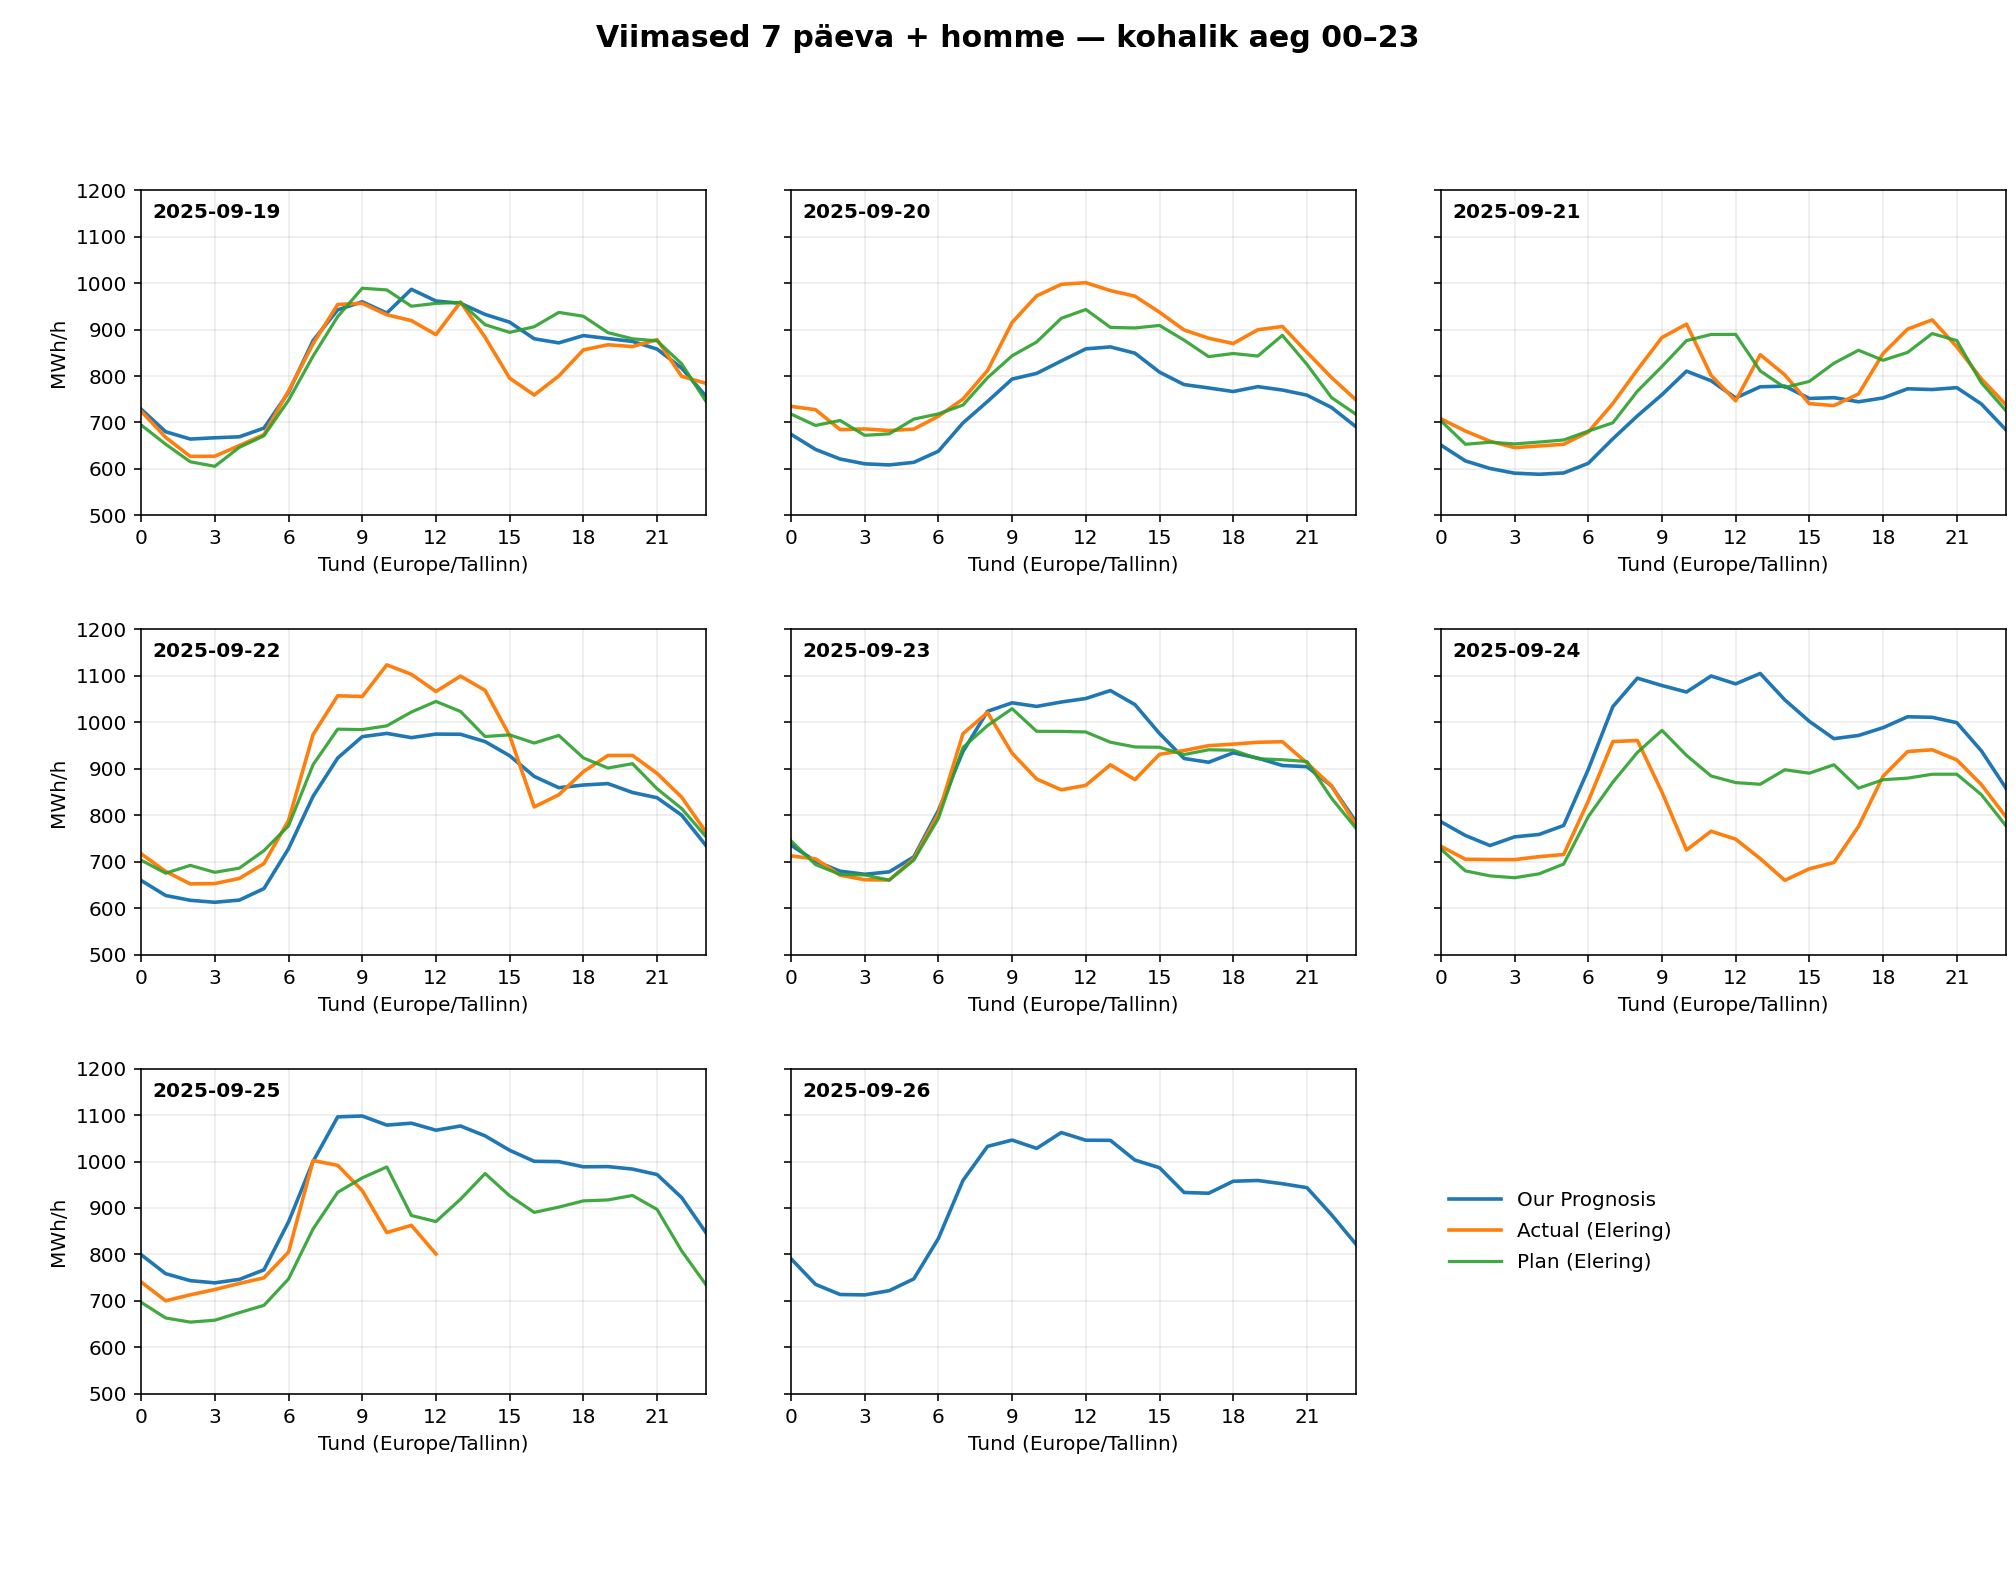

In [585]:
# === Statiivne <details>-põhine HTML eksport (uuendatud) ===
from datetime import datetime
from pathlib import Path
from IPython.display import HTML, display
import html as _html
import base64, mimetypes, pandas as pd, numpy as np

PLOTS_DIR = globals().get('PLOTS_DIR', Path.cwd())
DAY_FILTER = globals().get('DAY_FILTER', '')
REQUIRE_PLAN = globals().get('REQUIRE_PLAN', False)

panel_png = globals().get('panel_png', PLOTS_DIR / f"panel_local_{DAY_FILTER}{'_planreq' if REQUIRE_PLAN else ''}.png")
_raw_panel = globals().get('panel_uri', panel_png)
ape_block  = globals().get('ape_section', globals().get('ape_html'))
metrics_block_src = globals().get('metrics_html')  # ← kasutame A-ploki väljundit

def to_data_uri(x):
    if not x: return None
    p = Path(str(x))
    if p.is_file():
        mime = mimetypes.guess_type(p.name)[0] or 'image/png'
        return f"data:{mime};base64,{base64.b64encode(p.read_bytes()).decode('ascii')}"
    return None

panel_data_uri = to_data_uri(_raw_panel)
now_ts = datetime.now().strftime('%Y-%m-%d %H:%M')

def section(title: str, body_html: str, open: bool = True) -> str:
    return f"""
    <details {'open' if open else ''} class='card'>
      <summary>{_html.escape(title)}</summary>
      <div class='body'>{body_html}</div>
    </details>
    """

# Kui metrics_html mingil põhjusel puudub, näita hoiatust
if not metrics_block_src:
    metrics_block_src = "<div style='color:#b91c1c'>Päevamõõdikute HTML puudub (metrics_html).</div>"

metrics_block = (
    "<div class='subtle'>Selgitus: "
    "sum_abs_err_MWh = päevane absoluutvea summa (Our vs Actual, ainult kattuvatel tundidel). "
    "elering_sum_abs_err_MWh = Eleringi plaani (Plan) vs Actual päevane absoluutvea summa (snapshot/fallback). "
    "our_day_sum_MWh = meie prognoosi 24h summa; actual_day_sum_MWh = tegeliku tarbimise 24h summa. "
    "avg_abs_err_MWh = tunnipõhiste absoluutvigade keskmine (Our vs Actual) ainult kattuvatel tundidel (N). "
    "max_abs_err_MWh = suurim tunnipõhine absoluutne viga (Our vs Actual). "
    "min_abs_err_MWh = väikseim tunnipõhine absoluutne viga (Our vs Actual). "
    "Ühik: MWh."
    "</div>" + metrics_block_src
)

panel_img_html = (
    f"<img src='{panel_data_uri}' alt='panel' style='max-width:1200px;width:100%;border:1px solid #e5e7eb;border-radius:8px'/>"
    if panel_data_uri else "<div style='color:#b91c1c'>Paneeli pildi data URI puudub</div>"
)

html_doc = f"""<!doctype html>
<html lang='et'>
<meta charset='utf-8'>
<title>Töölaua vaade (statiline)</title>
<meta name='viewport' content='width=device-width,initial-scale=1'/>
<style>
  body {{ font-family: system-ui, Arial, sans-serif; background:#f8fafc; margin:16px; color:#0f172a; }}
  h2 {{ margin:4px 0 12px; font-weight:600; }}
  .updated {{ font-size:12px; color:#475569; margin:-4px 0 14px; }}
  details.card {{ background:#ffffff; border:1px solid #e2e8f0; border-radius:10px; padding:8px 12px 12px; margin:14px 0; box-shadow:0 1px 2px rgba(0,0,0,0.05); }}
  details.card[open] {{ border-color:#94a3b8; }}
  details.card > summary {{ cursor:pointer; font-weight:600; font-size:15px; list-style:none; display:flex; align-items:center; gap:6px; }}
  details.card > summary::-webkit-details-marker {{ display:none; }}
  details.card > summary:before {{ content:'▶'; font-size:11px; color:#475569; transition:transform .15s ease; }}
  details.card[open] > summary:before {{ transform:rotate(90deg); }}
  details.card .body {{ margin-top:10px; }}

  /* Tabeli kompaktne paigutus + päiste murdumine (sobib metrics_html Styleri väljastusele) */
  table {{ border-collapse:collapse; font-size:14px; table-layout:fixed; width:100%; }}
  th {{ background:#0f172a; color:#fff; text-align:center; padding:4px 8px;
       white-space:normal; overflow-wrap:anywhere; word-break:break-word; max-width:12ch; }}
  td {{ padding:4px 8px; font-variant-numeric: tabular-nums; text-align:right; }}
  .subtle {{ color:#475569; font-size:12px; margin:0 0 6px 2px; }}
</style>
<body>
  <h2>Töölaua vaade</h2>
  <div class='updated'>Genereeritud: {now_ts}</div>
  {section('Joondiagrammide paneel — viimased 7 päeva + homme', panel_img_html, open=True)}
  {section('Päevamõõdikud', metrics_block, open=False)}
  {section('APE% (Our vs Actual) — tunnid × päevad — sparklines', ape_block or '<div style="color:#6b7280"><em>APE% plokk puudub.</em></div>', open=False)}
</body>
</html>"""

out_html = PLOTS_DIR / 'dashboard_details.html'
out_html.write_text(html_doc, encoding='utf-8')
print("Salvestatud statiline HTML:", out_html)

docs_dir = Path.cwd().parent / 'docs'
docs_dir.mkdir(exist_ok=True)
docs_target = docs_dir / 'dashboard_details.html'
docs_target.write_text(html_doc, encoding='utf-8')
print("Kopeeritud GitHub Pages jaoks:", docs_target)

display(HTML(html_doc))